# SALT \begin{equation*} \frac{\partial V}{\partial t} = \Psi + \Omega \end{equation*}
## **SOSE**

In [1]:
from dask.distributed import Client

client = Client("tcp://10.32.16.194:38301")
client

Client Scheduler: tcp://10.32.16.194:38301 Dashboard: /user/0000-0002-8176-9465/proxy/8787/status,Cluster Workers: 19 Cores: 38 Memory: 218.50 GB


In [2]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
from xhistogram.xarray import histogram
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
%matplotlib inline

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['geojson', 'postgis', 'shapefile', 'spatialite'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [3]:
xr.set_options(display_style='text')

In [4]:
#WG boundaries (65˚W, 30˚E; 80˚S, 62˚S)
#WG model's boundaries (-77.87497˚S, -62.041634˚S; 295.08334W, 30.083334E)
lower_lat = 0
upper_lat = 95
left_lon =  310
right_lon = 880
XG_left = 309
XG_right = 881
YG_upper = 96

In [5]:
#set the boundaries
lat_range = dict(YC=slice(lower_lat, upper_lat), YG=slice(lower_lat, YG_upper))
lon_range = dict(XC=slice(left_lon, right_lon), XG=slice(left_lon, XG_right))

In [6]:
#set the boundaries
lat_range_noface = dict(YC=slice(lower_lat, upper_lat))
lon_range_noface = dict(XC=slice(left_lon, right_lon))

In [9]:
base_dir = 'pangeo-tmp/stb2145/SOSE/datasets/'
coords = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/coords_wg.zarr')) #didn't upload wg region
ds_tns = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/ds_tns.zarr'))
ds_slt = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/ds_slt_wg.zarr'))
ds_vel = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/ds_vel.zarr'))
ds = xr.merge([ds_tns, ds_slt, ds_vel])
ds

<xarray.Dataset>
Dimensions:                   (XC: 570, XG: 571, YC: 95, YG: 96, Z: 42, Zl: 42, time: 438)
Coordinates:
  * XC                        (XC) float32 295.08334 295.25 ... 29.75 29.916668
  * YC                        (YC) float32 -77.87497 -77.7083 ... -62.2083
  * Z                         (Z) float32 -5.0 -15.5 -27.0 ... -5325.0 -5575.0
  * time                      (time) datetime64[ns] 2005-01-06 ... 2010-12-31
  * XG                        (XG) float32 295.0 295.1667 ... 29.833334 30.0
  * YG                        (YG) float32 -77.9583 -77.79163 ... -62.124966
  * Zl                        (Zl) float32 0.0 -10.0 -21.0 ... -5200.0 -5450.0
Data variables:
    ETAN                      (time, YC, XC) float32 dask.array<chunksize=(1, 95, 570), meta=np.ndarray>
    SALT                      (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    THETA                     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_horiz_adv_flux_SLT   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_horiz_diff_flux_SLT  (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_vert_adv_flux_SLT    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_vert_diff_flux_SLT   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    lin_fs_correction_SLT     (time, YC, XC) float32 dask.array<chunksize=(1, 95, 570), meta=np.ndarray>
    surface_flux_conv_SLT     (time, YC, XC) float32 dask.array<chunksize=(1, 95, 570), meta=np.ndarray>
    total_tendency_SLT_truth  (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    UVEL                      (time, Z, YC, XG) float32 dask.array<chunksize=(1, 42, 95, 571), meta=np.ndarray>
    VVEL                      (time, Z, YG, XC) float32 dask.array<chunksize=(1, 42, 96, 570), meta=np.ndarray>
    WSLTMASS                  (time, Zl, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    WTHMASS                   (time, Zl, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    WVEL                      (time, Zl, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    surForcS                  (time, YC, XC) float32 dask.array<chunksize=(1, 95, 570), meta=np.ndarray>
    surForcT                  (time, YC, XC) float32 dask.array<chunksize=(1, 95, 570), meta=np.ndarray>

In [10]:
coords_no_polynya = coords.isel(time=slice(72,  -1))
ds_no_polynya = ds.isel(time=slice(72,  -1))

In [11]:
ds_no_polynya.time

<xarray.DataArray 'time' (time: 365)>
array(['2006-01-01T00:00:00.000000000', '2006-01-06T00:00:00.000000000',
       '2006-01-11T00:00:00.000000000', ..., '2010-12-16T00:00:00.000000000',
       '2010-12-21T00:00:00.000000000', '2010-12-26T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2006-01-01 2006-01-06 ... 2010-12-26
Attributes:
    axis:           T
    long_name:      Time
    standard_name:  time

In [12]:
ds = ds.chunk({'time':5})
ds.nbytes/1e9

52.322753328

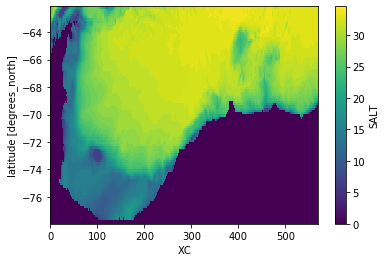

In [13]:
#can't plot w dask cluster
ds.SALT.mean(dim=['time', 'Z']).drop('XC').plot()

In [14]:
terms = ['conv_horiz_adv_flux_SLT', 'conv_horiz_diff_flux_SLT',
         'conv_vert_adv_flux_SLT', 'conv_vert_diff_flux_SLT',
         'surface_flux_conv_SLT', 'lin_fs_correction_SLT']

In [15]:
total = sum(ds[term] for term in terms)

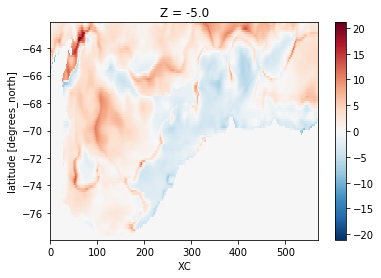

In [16]:
total.isel(Z=0).mean(dim='time').drop('XC').plot()

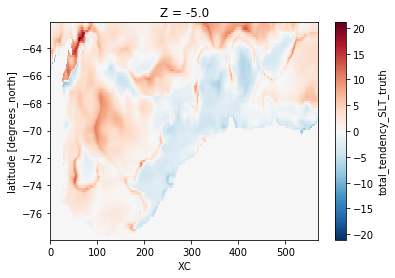

In [19]:
ds.total_tendency_SLT_truth.isel(Z=0).mean(dim='time').drop('XC').plot()

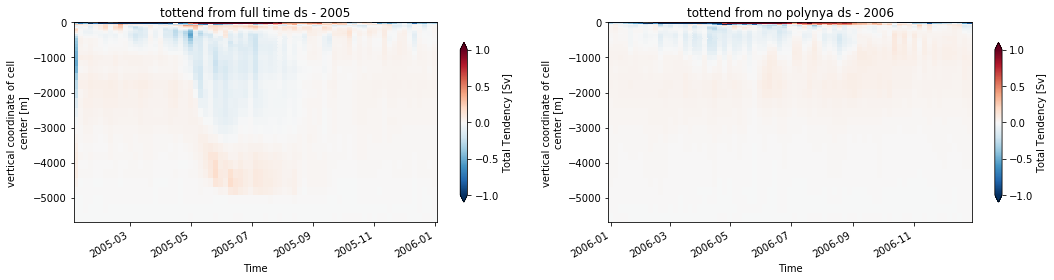

In [20]:
fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(15,4))
(ds/1e6).total_tendency_SLT_truth.isel(time=slice(0,73)).sum(dim=['XC', 'YC']).plot(y='Z', ax=ax0, 
                                              cbar_kwargs={'shrink':0.8, 'label':'Total Tendency [Sv]'}, vmax=1)
ax0.set_title('tottend from full time ds - 2005')

(ds_no_polynya/1e6).total_tendency_SLT_truth.isel(time=slice(0,73)).sum(dim=['XC', 'YC']).plot(y='Z', ax=ax1,
                                                         cbar_kwargs={'shrink':0.8, 'label':'Total Tendency [Sv]'}, vmax=1)
ax1.set_title('tottend from no polynya ds - 2006')

plt.tight_layout();

# <font color='Green'>\begin{equation*} \frac{\partial V}{\partial t} == \Omega_{tottend-SLT-truth} + R1 \end{equation*} </font>

In [33]:
# define bins
delta_salt = 0.1
salt_bins = np.arange(32, 35, delta_salt)

In [40]:
# salt distribution in WG region
vol = (coords.hFacC * coords.rA * coords.drF).isel(**lat_range_noface, **lon_range_noface)

salt_dist = histogram(ds_no_polynya.SALT, bins=[salt_bins],
                       weights=vol, dim=['XC', 'YC', 'Z']).rename({'SALT_bin':'salt_bin'}) / delta_salt
salt_dist.load()

<xarray.DataArray 'histogram_SALT' (time: 365, salt_bin: 29)>
array([[9.24418510e+11, 1.41421901e+12, 1.56392822e+12, ...,
        1.47939101e+17, 5.45467313e+15, 0.00000000e+00],
       [9.86390760e+11, 7.15159529e+11, 8.13634171e+11, ...,
        1.47935029e+17, 5.45878396e+15, 0.00000000e+00],
       [5.60634702e+11, 6.32360215e+11, 7.32092877e+11, ...,
        1.47933162e+17, 5.46029056e+15, 0.00000000e+00],
       ...,
       [1.40882794e+11, 1.23587012e+11, 9.16530522e+10, ...,
        1.47743620e+17, 6.02941037e+15, 0.00000000e+00],
       [2.17910241e+11, 9.23223053e+10, 1.50489334e+11, ...,
        1.47727291e+17, 6.03697060e+15, 0.00000000e+00],
       [1.70909012e+11, 5.82225766e+10, 5.97615987e+10, ...,
        1.47710615e+17, 6.05389447e+15, 0.00000000e+00]])
Coordinates:
  * time      (time) datetime64[ns] 2006-01-01 2006-01-06 ... 2010-12-26
  * salt_bin  (salt_bin) float64 32.05 32.15 32.25 32.35 ... 34.65 34.75 34.85

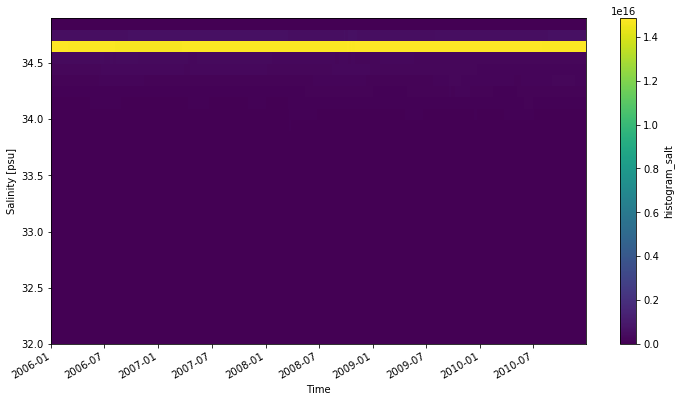

In [41]:
# theta distribution in WG region
salt_dist = histogram(ds_no_polynya.SALT.rename('salt'), bins=[salt_bins],
                       weights=vol, dim=['XC', 'YC', 'Z']).load()
salt_dist.plot(x='time', figsize=(12, 6))

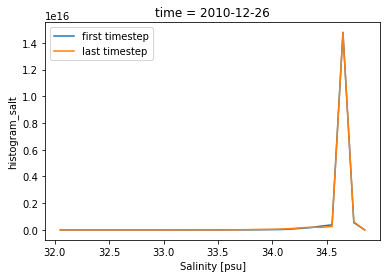

In [42]:
salt_dist[0].plot(label='first timestep')
salt_dist[-1].plot(label='last timestep')
plt.legend();

(34, 34.900000000000034)

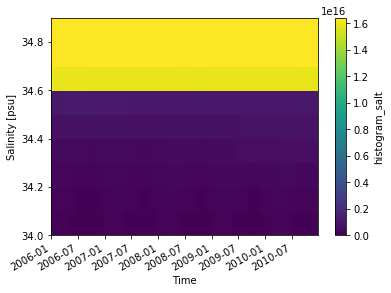

In [44]:
# cumulative volume
V = salt_dist.cumsum(dim='salt_bin')
V.transpose().plot()
plt.ylim(ymin=34)

In [45]:
V

<xarray.DataArray 'histogram_salt' (time: 365, salt_bin: 29)>
array([[9.24418510e+10, 2.33863752e+11, 3.90256573e+11, ...,
        1.58719036e+16, 1.64173709e+16, 1.64173709e+16],
       [9.86390760e+10, 1.70155029e+11, 2.51518446e+11, ...,
        1.58712714e+16, 1.64171498e+16, 1.64171498e+16],
       [5.60634702e+10, 1.19299492e+11, 1.92508779e+11, ...,
        1.58710732e+16, 1.64171023e+16, 1.64171023e+16],
       ...,
       [1.40882794e+10, 2.64469806e+10, 3.56122858e+10, ...,
        1.58144725e+16, 1.64174136e+16, 1.64174136e+16],
       [2.17910241e+10, 3.10232547e+10, 4.60721880e+10, ...,
        1.58137273e+16, 1.64174244e+16, 1.64174244e+16],
       [1.70909012e+10, 2.29131589e+10, 2.88893188e+10, ...,
        1.58120239e+16, 1.64174133e+16, 1.64174133e+16]])
Coordinates:
  * time      (time) datetime64[ns] 2006-01-01 2006-01-06 ... 2010-12-26
  * salt_bin  (salt_bin) float64 32.05 32.15 32.25 32.35 ... 34.65 34.75 34.85

In [46]:
V_mean = V.mean(dim='time')
V_anom = V - V_mean

## $\frac{\partial \mathcal{V}}{\partial t}$

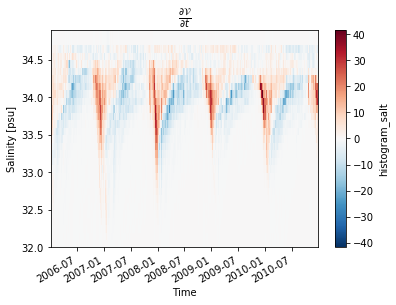

In [50]:
dt = 5*24*60*60
#using V_anom bc there is no change in V_mean
dVdt = V_anom.diff(dim='time') / dt
(dVdt/1e6).plot(x='time')
plt.title(r'$\frac{\partial \mathcal{V}}{\partial t}$', fontsize=14, weight='bold');

## $\Omega_{total}$

In [51]:
omega_total = - histogram(ds_no_polynya.SALT.rename('salt'), bins=[salt_bins],
                         weights=ds_no_polynya.total_tendency_SLT_truth,
                         dim=['XC', 'YC', 'Z']) / delta_salt

In [52]:
omega_total = omega_total[1:].load()

In [53]:
omega_total

<xarray.DataArray 'histogram_salt' (time: 364, salt_bin: 29)>
array([[ 2.18587586e+05,  1.24934051e+05,  1.13752219e+05, ...,
        -4.78957320e+06,  1.02155414e+05, -0.00000000e+00],
       [-1.49475075e+04, -4.02252858e+04, -1.81102607e+04, ...,
        -3.98768815e+06,  1.90052637e+05, -0.00000000e+00],
       [-4.89011597e+04,  2.01177620e+04,  1.09244558e+04, ...,
        -3.15626060e+06,  1.20910040e+05, -0.00000000e+00],
       ...,
       [-8.32195119e+03, -3.27053583e+04, -1.26148200e+04, ...,
        -2.11492445e+06, -2.59206829e+04, -0.00000000e+00],
       [ 7.91419442e+03, -2.04522530e+04,  1.78668519e+04, ...,
        -4.14988416e+06, -6.48142008e+04, -0.00000000e+00],
       [-8.36847569e+03, -1.15512505e+04, -3.01267037e+03, ...,
        -3.86488960e+06, -2.11456508e+05, -0.00000000e+00]])
Coordinates:
  * time      (time) datetime64[ns] 2006-01-06 2006-01-11 ... 2010-12-26
  * salt_bin  (salt_bin) float64 32.05 32.15 32.25 32.35 ... 34.65 34.75 34.85

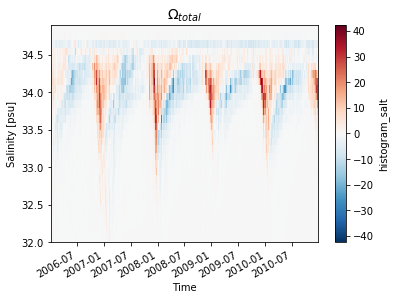

In [67]:
(omega_total/1e6).plot(x='time')
plt.title(r'$\Omega_{total}$', fontsize=14, weight='bold');

## <font color='Green'>\begin{equation*} R1 = \frac{\partial \mathcal{V}}{\partial t} - \Omega_{total} \end{equation*} (Discretization of salt layers) </font>

In [58]:
R1 = dVdt - omega_total
R1.load()

<xarray.DataArray 'histogram_salt' (time: 364, salt_bin: 29)>
array([[-2.04242158e+05, -2.72407946e+05, -4.34905292e+05, ...,
         3.32617048e+06, -6.13977016e+05, -5.11821602e+05],
       [-8.36071355e+04, -7.74958650e+04, -1.18486190e+05, ...,
         3.52889332e+06, -3.00098731e+05, -1.10046093e+05],
       [ 5.32381094e+04, -1.53214758e+04, -1.34302635e+04, ...,
         4.23089439e+06, -1.25717625e+05, -4.80758519e+03],
       ...,
       [ 1.72545430e+03,  1.11559803e+04, -9.12915337e+03, ...,
         2.26833598e+06,  1.43444637e+04, -1.15762193e+04],
       [ 9.91623314e+03,  3.10454800e+04,  6.34588467e+03, ...,
         2.42484475e+06,  8.98281338e+04,  2.50139330e+04],
       [-2.51143838e+03, -7.22211931e+03, -3.67624899e+04, ...,
        -7.83204408e+04,  1.85808437e+05, -2.56480708e+04]])
Coordinates:
  * time      (time) datetime64[ns] 2006-01-06 2006-01-11 ... 2010-12-26
  * salt_bin  (salt_bin) float64 32.05 32.15 32.25 32.35 ... 34.65 34.75 34.85

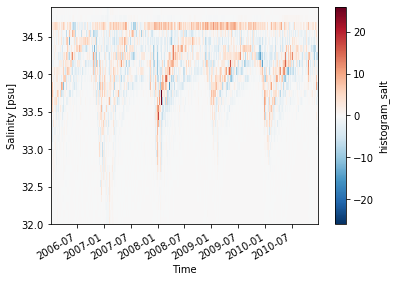

In [59]:
(R1/1e6).plot(x='time')

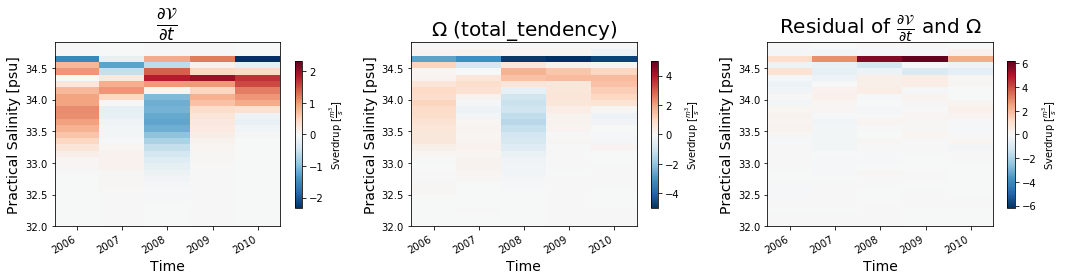

In [62]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 4), sharex=True)

(dVdt/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=ax0,
                                                     cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax0.set_ylabel('Practical Salinity [psu]', fontsize=14)
ax0.set_xlabel('Time', fontsize=14)
ax0.set_title(r'$\frac{\partial \mathcal{V}}{\partial t}$', fontsize=24)

(omega_total/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=ax1, 
                                                            cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax1.set_ylabel('Practical Salinity [psu]', fontsize=14)
ax1.set_xlabel('Time', fontsize=14)
ax1.set_title('$\Omega$ (total_tendency)', fontsize=20)

(R1/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=ax2, 
                                                   cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax2.set_ylabel('Practical Salinity [psu]', fontsize=14)
ax2.set_xlabel('Time', fontsize=14)
ax2.set_title(r'Residual of $\frac{\partial \mathcal{V}}{\partial t}$ and $\Omega$', fontsize=20)

plt.tight_layout();

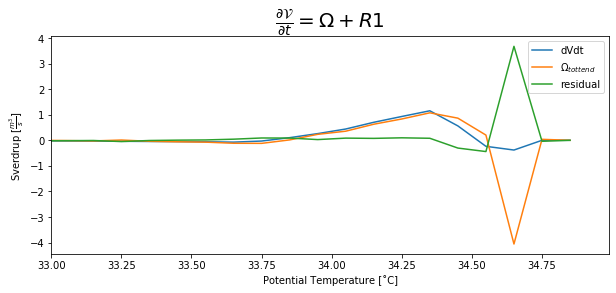

In [65]:
plt.figure(figsize=(10, 4))
(dVdt/1e6).mean(dim='time').plot(label='dVdt')
(omega_total/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend}$')
(R1/1e6).mean(dim='time').plot(label='residual')
plt.ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
plt.xlabel('Potential Temperature [˚C]')
plt.legend()
plt.xlim(xmin=33)
plt.title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega + R1$', fontsize=20);

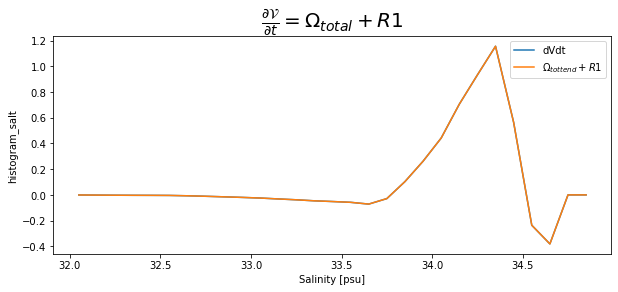

In [66]:
plt.figure(figsize=(10, 4))
(dVdt/1e6).mean(dim='time').plot(label='dVdt')
((omega_total + R1)/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend} + R1$')
plt.legend()
#plt.xlim(xmax=4)
plt.title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$', fontsize=20);

## <font color='Green'> \begin{equation*} \Psi_{adv} = \Psi_{vel} + R2 \end{equation*} (Numerical Mixing) </font>

## $\Psi_{adv}$

In [87]:
psi_adv = -(all_dsets.OMEGA_conv_horiz_adv_flux_SLT + all_dsets.OMEGA_conv_vert_adv_flux_SLT)
psi_adv = psi_adv[1:].load()

In [88]:
psi_adv

<xarray.DataArray (time: 364, salt_bin: 29)>
array([[-4.53033627e+05, -2.42766064e+05, -1.96776453e+04, ...,
        -6.75658812e+06, -2.48385785e+05, -0.00000000e+00],
       [-1.31802138e+05, -1.13573037e+05, -1.11777531e+05, ...,
        -5.89830956e+06, -1.59607555e+05, -0.00000000e+00],
       [ 1.61714718e+05,  1.63548680e+05,  5.28123820e+04, ...,
        -5.09775990e+06, -2.36177641e+05, -0.00000000e+00],
       ...,
       [-2.69857996e+04, -5.00859302e+04, -3.33591406e+04, ...,
        -4.71360425e+06, -3.73575318e+05, -0.00000000e+00],
       [-4.00784912e+04, -2.94448242e+04, -7.93791614e+04, ...,
        -6.66137044e+06, -4.48138616e+05, -0.00000000e+00],
       [ 1.37210449e+03,  9.06002930e+03,  1.21152002e+04, ...,
        -6.39295197e+06, -5.38654916e+05, -0.00000000e+00]])
Coordinates:
  * time      (time) datetime64[ns] 2006-01-06 2006-01-11 ... 2010-12-26
  * salt_bin  (salt_bin) float64 32.05 32.15 32.25 32.35 ... 34.65 34.75 34.85

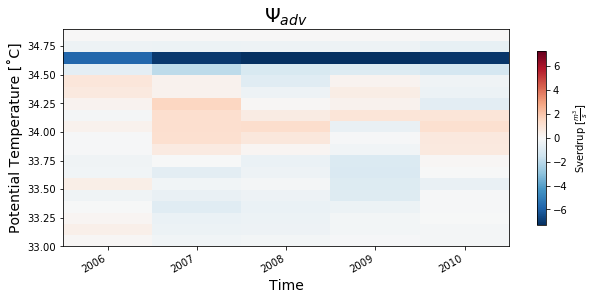

In [113]:
(psi_adv/1e6).resample(time='AS').mean(dim='time').plot(x='time', figsize=(10,4), 
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup $[\frac{m^3}{s}]$'})
plt.ylabel('Potential Temperature [˚C]', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.ylim(ymin=33)
plt.title(r'$\Psi_{adv}$', fontsize=20);

## $\Psi_{vel}$

In [91]:
#m^3/s #(-) values -> westward, (+) values -> east
u_transport_right = (ds_no_polynya.UVEL * coords_no_polynya.dyG * coords_no_polynya.drF).isel(XG=-1) 
u_transport_left = (ds_no_polynya.UVEL * coords_no_polynya.dyG * coords_no_polynya.drF).isel(XG=0)
#m^3/s #(-) values -> south, (+) values -> north
v_transport = (ds_no_polynya.VVEL * coords_no_polynya.dxG * coords_no_polynya.drF).isel(YG=-1) 
#m^3/s #(-) values are massflux into the ocean, (+) values are massflux out of the ocean
w_transport = ds_no_polynya.WVEL.isel(Zl=0) * coords_no_polynya.rA 

In [92]:
u_transport_mean_value = (u_transport_right.sum(['Z', 'YC']) - 
                          u_transport_left.sum(['Z', 'YC'])).mean()/1e6
u_transport_mean_value.load()

<xarray.DataArray ()>
array(-45.439007, dtype=float32)

In [93]:
v_transport_mean_value = v_transport.mean(dim='time').sum(['XC', 'Z'])/1e6
v_transport_mean_value.load()

<xarray.DataArray ()>
array(46.38442, dtype=float32)
Coordinates:
    YG       float64 -62.12

In [94]:
w_transport_mean_value = w_transport.mean(dim='time').sum(['XC', 'YC'])/1e6
w_transport_mean_value.load()

<xarray.DataArray ()>
array(0.00321968, dtype=float32)
Coordinates:
    Zl       float32 0.0

In [95]:
residual = u_transport_mean_value + v_transport_mean_value + w_transport_mean_value
residual.values

array(0.94863135, dtype=float32)

In [108]:
# hack salt to be on same grid pt as velocity components
salt_at_u_right = ds_no_polynya.SALT.rename('salt').isel(XC=-1)
salt_at_u_left = ds_no_polynya.SALT.rename('salt').isel(XC=0)
salt_at_v = ds_no_polynya.SALT.rename('salt').isel(YC=-1)
salt_at_w = ds_no_polynya.SALT.rename('salt').isel(Z=0)

In [109]:
#this is the delta function part of the equation above
u_binned_right = histogram(salt_at_u_right, bins=[salt_bins],
                           weights=u_transport_right, dim=['Z', 'YC']).load()
u_binned_left = histogram(salt_at_u_left, bins=[salt_bins],
                          weights=u_transport_left, dim=['Z', 'YC']).load()
v_binned = histogram(salt_at_v, bins=[salt_bins],
                     weights=v_transport, dim=['Z', 'XC']).load()
w_binned = histogram(salt_at_w, bins=[salt_bins],
                     weights=w_transport, dim=['XC', 'YC']).load()

In [110]:
psi_vel = -(u_binned_right + u_binned_left + v_binned).cumsum(dim='salt_bin')
psi_vel = psi_vel[1:].load()

In [111]:
psi_vel

<xarray.DataArray 'histogram_salt' (time: 364, salt_bin: 29)>
array([[-1.35946774e+04, -1.64040827e+04, -2.48297400e+04, ...,
        -1.91258838e+07, -3.49669217e+07, -3.49669217e+07],
       [-8.07102441e+03, -1.29836772e+04, -1.28134656e+04, ...,
        -1.88822393e+07, -4.23163962e+07, -4.23163962e+07],
       [-2.86316097e+03, -1.07945130e+04, -1.45986778e+04, ...,
        -2.10910419e+07, -4.27588165e+07, -4.27588165e+07],
       ...,
       [ 7.58853857e+03,  1.31779907e+03,  3.15681445e+03, ...,
        -2.05640165e+07, -2.72897175e+07, -2.72897175e+07],
       [-5.18239380e+03, -5.18239380e+03, -5.18239380e+03, ...,
        -2.35134504e+07, -3.10656720e+07, -3.10656720e+07],
       [ 7.65941760e+03,  7.65941760e+03,  7.65941760e+03, ...,
        -2.40876883e+07, -2.87450786e+07, -2.87450786e+07]])
Coordinates:
  * time      (time) datetime64[ns] 2006-01-06 2006-01-11 ... 2010-12-26
  * salt_bin  (salt_bin) float64 32.05 32.15 32.25 32.35 ... 34.65 34.75 34.85

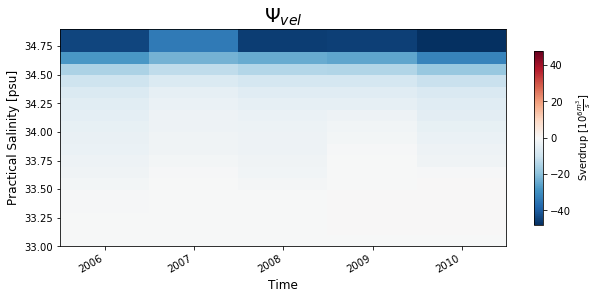

In [114]:
(psi_vel/1e6).resample(time='AS').mean(dim='time').plot(x='time', figsize=(10,4), 
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$10^{6} \frac{m^3}{s}$]'})
plt.ylabel('Practical Salinity [psu]', fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.ylim(ymin=33)
plt.title('$\Psi_{vel}$', fontsize=20);

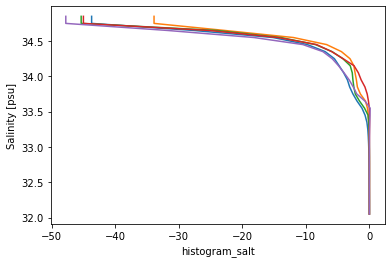

In [116]:
(psi_vel/1e6).resample(time='AS').mean(dim='time').plot.line(y='salt_bin', add_legend=False);

## R2 = $\Psi_{adv} - \Psi_{vel}$

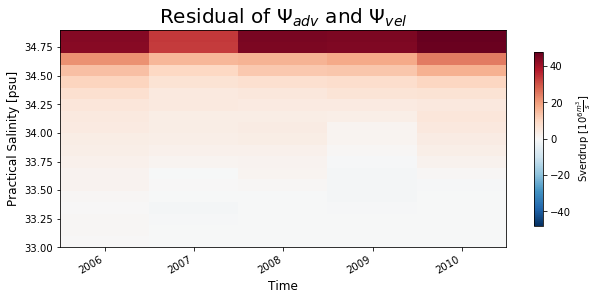

In [118]:
R2 = psi_adv - psi_vel
(R2/1e6).resample(time='AS').mean(dim='time').plot(x='time', figsize=(10,4), 
                                                   cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$10^{6} \frac{m^3}{s}$]'})
plt.ylabel('Practical Salinity [psu]', fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.ylim(ymin=33)
plt.title(r'Residual of $\Psi_{adv}$ and $\Psi_{vel}$', fontsize=20);

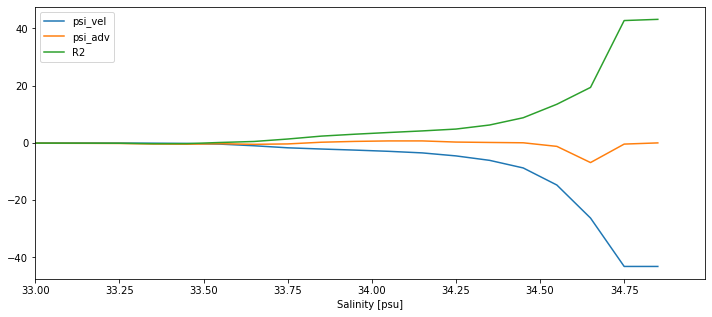

In [120]:
plt.figure(figsize=(12, 5))
(psi_vel/1e6).mean(dim='time').plot(label='psi_vel')
(psi_adv/1e6).mean(dim='time').plot(label='psi_adv')
(R2/1e6).mean(dim='time').plot(label='R2')
plt.xlim(xmin=33)
plt.legend();

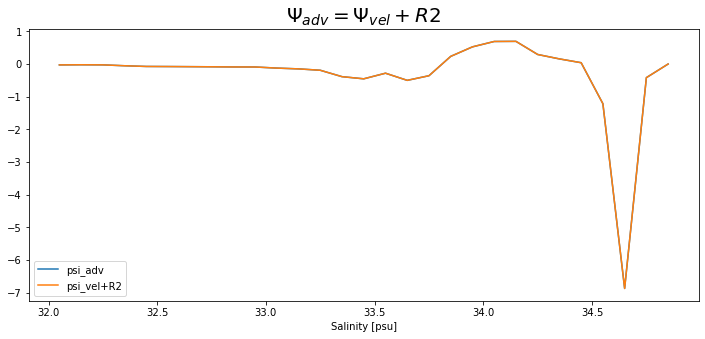

In [121]:
plt.figure(figsize=(12,5))
(psi_adv/1e6).mean(dim='time').plot(label='psi_adv')
((psi_vel+R2)/1e6).mean(dim='time').plot(label='psi_vel+R2')
plt.title(r'$\Psi_{adv} = \Psi_{vel} + R2$', fontsize=20, weight='bold')
plt.legend();

## <span style='color:Green'> \begin{equation*} \Omega_{transformation-rate} \end{equation*}

In [75]:
ds_slt_no_polynya = ds_slt.isel(time=slice(72, -1)).chunk({'XC':-1, 'YC':-1, 'Z':-1, 'time':1})

In [71]:
def histogram_func(variable):
    """Generalized xhistogram's histogram function 
    for adv and diff flux terms"""
    hist = histogram(ds_no_polynya.SALT.rename('salt'), bins=[salt_bins],
                     weights=variable, dim=['XC', 'YC', 'Z'])
    return hist / delta_salt

In [77]:
all_tendencies = list(ds_slt_no_polynya)
all_tendencies

['conv_horiz_adv_flux_SLT',
 'conv_horiz_diff_flux_SLT',
 'conv_vert_adv_flux_SLT',
 'conv_vert_diff_flux_SLT',
 'lin_fs_correction_SLT',
 'surface_flux_conv_SLT',
 'total_tendency_SLT_truth']

In [78]:
all_dsets = xr.merge([histogram_func(ds_slt_no_polynya[var]).rename('OMEGA_' + var)
                      for var in all_tendencies])
all_dsets

<xarray.Dataset>
Dimensions:                         (salt_bin: 29, time: 365)
Coordinates:
  * time                            (time) datetime64[ns] 2006-01-01 ... 2010-12-26
  * salt_bin                        (salt_bin) float64 32.05 32.15 ... 34.85
Data variables:
    OMEGA_conv_horiz_adv_flux_SLT   (time, salt_bin) float64 dask.array<chunksize=(1, 29), meta=np.ndarray>
    OMEGA_conv_horiz_diff_flux_SLT  (time, salt_bin) float64 dask.array<chunksize=(1, 29), meta=np.ndarray>
    OMEGA_conv_vert_adv_flux_SLT    (time, salt_bin) float64 dask.array<chunksize=(1, 29), meta=np.ndarray>
    OMEGA_conv_vert_diff_flux_SLT   (time, salt_bin) float64 dask.array<chunksize=(1, 29), meta=np.ndarray>
    OMEGA_lin_fs_correction_SLT     (time, salt_bin) float64 dask.array<chunksize=(1, 29), meta=np.ndarray>
    OMEGA_surface_flux_conv_SLT     (time, salt_bin) float64 dask.array<chunksize=(1, 29), meta=np.ndarray>
    OMEGA_total_tendency_SLT_truth  (time, salt_bin) float64 dask.array<chunksize=(1, 29), meta=np.ndarray>

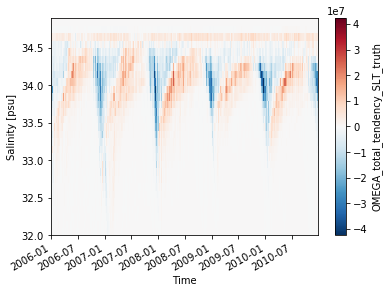

In [80]:
all_dsets.OMEGA_total_tendency_SLT_truth.plot(x='time')

In [81]:
omega_trans_rate = - (all_dsets.OMEGA_conv_horiz_diff_flux_SLT + 
                      all_dsets.OMEGA_conv_vert_diff_flux_SLT +
                      all_dsets.OMEGA_surface_flux_conv_SLT +
                      all_dsets.OMEGA_lin_fs_correction_SLT)
omega_trans_rate = omega_trans_rate[1:].load()

In [82]:
omega_trans_rate

<xarray.DataArray (time: 364, salt_bin: 29)>
array([[ 9.23835936e+05,  7.64049366e+05,  7.49673787e+05, ...,
         1.58314501e+09,  1.84870444e+07, -0.00000000e+00],
       [ 2.91403620e+05,  4.18265667e+05,  5.72277683e+05, ...,
         9.54300908e+09, -1.96663287e+08, -0.00000000e+00],
       [-4.25226065e+05, -3.24848504e+05, -2.21541792e+05, ...,
        -2.97765619e+09,  5.05603425e+08, -0.00000000e+00],
       ...,
       [ 5.01633358e+04,  1.02052190e+05,  1.92003504e+04, ...,
         9.70351296e+09,  9.20785783e+07, -0.00000000e+00],
       [ 1.50196821e+05, -1.30776831e+04,  1.78484289e+05, ...,
        -5.16179418e+09,  3.54066731e+08, -0.00000000e+00],
       [-7.82826266e+04, -2.06112910e+04, -3.15768858e+04, ...,
        -1.06165569e+09, -6.48550685e+08, -0.00000000e+00]])
Coordinates:
  * time      (time) datetime64[ns] 2006-01-06 2006-01-11 ... 2010-12-26
  * salt_bin  (salt_bin) float64 32.05 32.15 32.25 32.35 ... 34.65 34.75 34.85

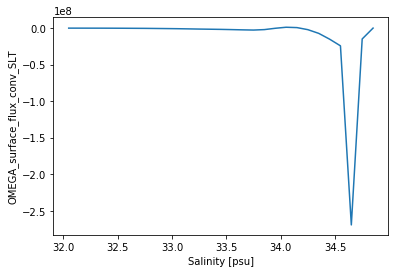

In [83]:
all_dsets.OMEGA_surface_flux_conv_SLT.mean(dim='time').plot()

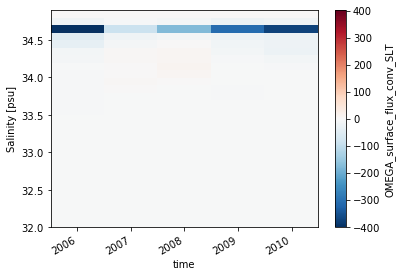

In [84]:
(all_dsets.OMEGA_surface_flux_conv_SLT.resample(time='AS').mean()/1e6).plot(x='time')

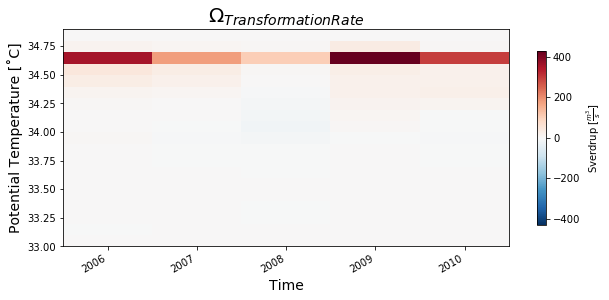

In [86]:
(omega_trans_rate.resample(time='AS').mean()/1e6).plot(x='time', figsize=(10,4), 
                                                       cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
plt.ylabel('Potential Temperature [˚C]', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.ylim(ymin=33)
plt.title(r'$\Omega_{Transformation Rate}$', fontsize=20);

# <font color='Green'>\begin{equation*} \frac{\partial V}{\partial t} = \Psi_{adv} + \Omega_{trans-rate} + R1 \end{equation*} </font>

(33.5, 35)

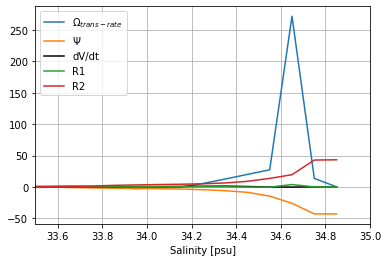

In [130]:
(omega_trans_rate/1e6).mean(dim='time').plot(label=r'$\Omega_{trans-rate}$')
(psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi$')
(dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k')
(R1/1e6).mean(dim='time').plot(label='R1')
(R2/1e6).mean(dim='time').plot(label='R2')
plt.legend()
plt.grid()
plt.xlim(33.5, 35)

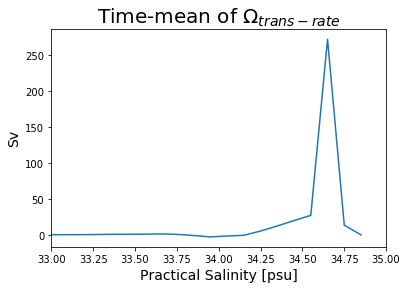

In [132]:
(omega_trans_rate/1e6).mean(dim='time').plot()
plt.xlim(33, 35)
plt.ylabel('Sv', fontsize=14)
plt.xlabel('Practical Salinity [psu]', fontsize=14)
plt.title(r'Time-mean of $\Omega_{trans-rate}$', fontsize=20);

In [134]:
omega_mix = -(all_dsets.OMEGA_conv_horiz_diff_flux_SLT + 
              all_dsets.OMEGA_conv_vert_diff_flux_SLT)[1:].load()
omega_surf = - (all_dsets.OMEGA_surface_flux_conv_SLT +
                all_dsets.OMEGA_lin_fs_correction_SLT)[1:].load()

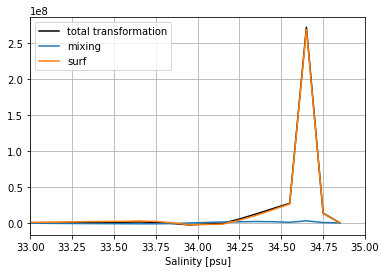

In [136]:
omega_trans_rate.mean(dim='time').plot(label='total transformation', color='k')
omega_mix.mean(dim='time').plot(label='mixing')
omega_surf.mean(dim='time').plot(label='surf')
plt.legend()
plt.grid()
plt.xlim(33, 35);

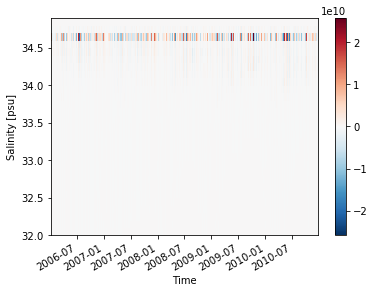

In [137]:
omega_surf.plot(x='time')

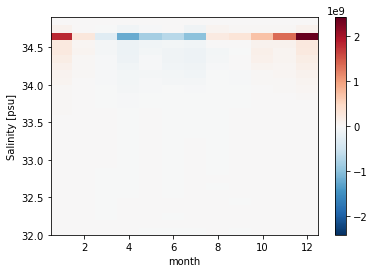

In [138]:
omega_surf.groupby('time.month').mean(dim='time').plot(x='month')

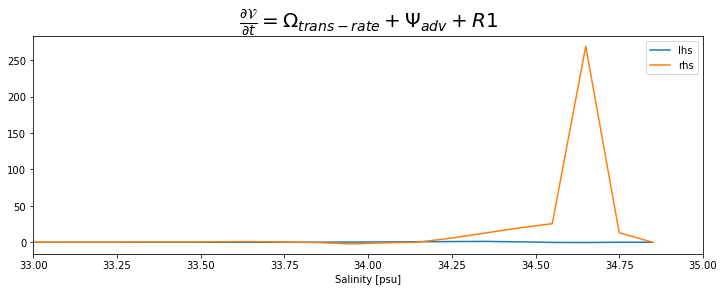

In [140]:
plt.figure(figsize=(12,4))
(dVdt/1e6).mean(dim='time').plot(label='lhs') 
((omega_trans_rate + R1 + psi_adv)/1e6).mean(dim='time').plot(label='rhs')
plt.title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega_{trans-rate} + \Psi_{adv} + R1$', fontsize=20, fontweight='bold')
plt.legend()
plt.xlim(33,35);

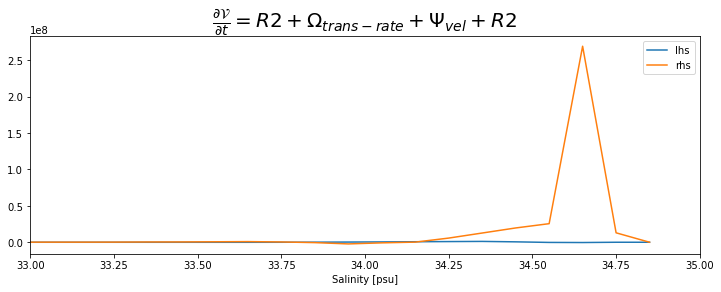

In [141]:
plt.figure(figsize=(12,4))
dVdt.mean(dim='time').plot(label='lhs') 
(omega_trans_rate + R1 + psi_vel + R2).mean(dim='time').plot(label='rhs')
plt.title(r'$\frac{\partial \mathcal{V}}{\partial t} = R2 + \Omega_{trans-rate} + \Psi_{vel} + R2$', fontsize=20, fontweight='bold')
plt.legend()
plt.xlim(33,35);

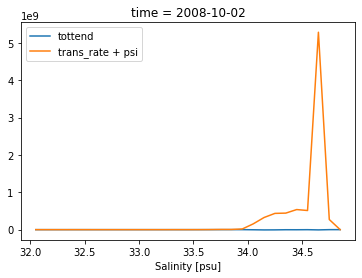

In [144]:
n = 200
omega_total.isel(time=n).plot(label='tottend')
(omega_trans_rate + psi_adv).isel(time=n).plot(label='trans_rate + psi')
plt.legend();